In [1]:
import os
import numpy as np
import pickle
import math
import scipy as sp
from scipy import interpolate
from numpy.linalg import solve
import matplotlib.pyplot as plt
from skimage.measure import profile_line
from time import time
import spekpy
import skimage
import copy
import matplotlib
import random

from skimage import color, io, measure, img_as_ubyte, img_as_float
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 

from cil.io import NikonDataReader, RAWFileWriter, TIFFStackReader, TIFFWriter
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.optimisation.algorithms import CGLS, SIRT

from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

from cil.io import NikonDataReader
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D, show1D
from cil.recon import FDK, FBP
from cil.plugins.tigre import ProjectionOperator#, FBP
from cil.processors import TransmissionAbsorptionConverter, AbsorptionTransmissionConverter, Slicer, Normaliser, Padder
from cil.optimisation.algorithms import CGLS, SIRT
from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.noise import gaussian, poisson

print(os.getcwd())
if os.getcwd() == "/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev":
    os.chdir('analysis/s214743_bsc')
    print(os.getcwd())

base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')

from sim_main import fun_attenuation, generate_spectrum, generate_triangle_image, staircase_bhc

from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu


def load_centre(filename):
    base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
    file_path = os.path.join(base_dir,f'centres/{filename}')
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    
    return data

/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev
/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc


In [2]:
from scipy.signal import savgol_filter

In [3]:
data = load_centre('X16_cor.pkl')
ag = data.geometry
ig = ag.get_ImageGeometry()

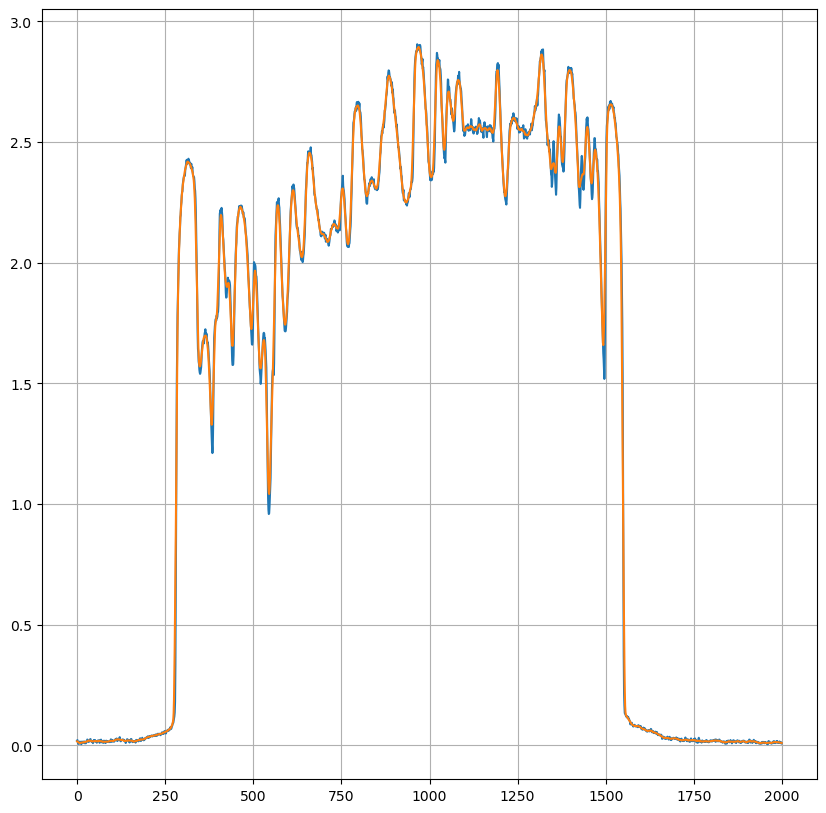

In [14]:
# chosen_angle = -3.2+65
chosen_angle = -3.2-400
idx_chosen_angle = np.argmin(np.mod(ag.angles - chosen_angle, 360))
chosen_angle2 = chosen_angle+180
idx_chosen_angle2 = np.argmin(np.mod(ag.angles - chosen_angle2, 360))


plt.figure(figsize=(10,10))

# plt.plot(AbsorptionTransmissionConverter()(data).as_array()[idx_chosen_angle,:])
# plt.yticks(np.linspace(0,1,21))

# plt.plot(data.as_array()[idx_chosen_angle,:])
# plt.plot(data.as_array()[idx_chosen_angle2,:])

data_slice = data.as_array()[idx_chosen_angle,:]
# filtered_data = np.clip(savgol_filter(data_slice, 200, 1),a_min=0,a_max=None)
filtered_data = savgol_filter(data_slice, 10, 1)
plt.plot(data_slice)
plt.plot(filtered_data)
# plt.plot(np.clip(data_slice - 0.5*filtered_data,a_min=0,a_max=None))
plt.grid(True)
plt.show()

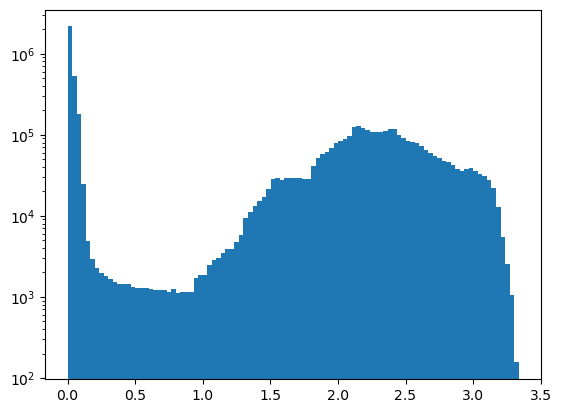

FDK recon

Input Data:
	angle: 3142
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



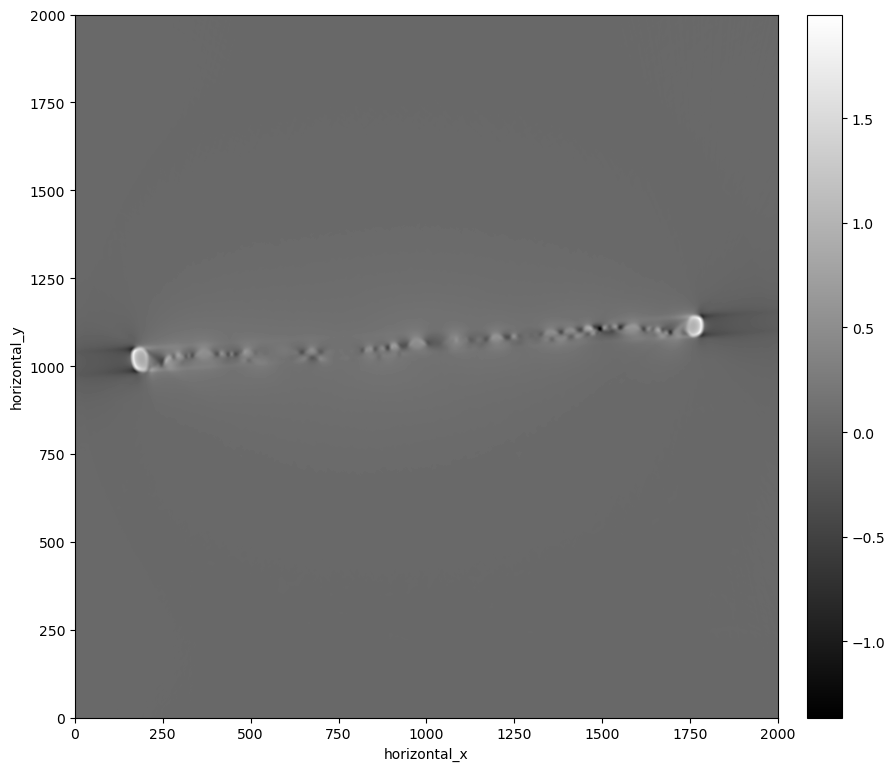

In [15]:
# filtered_data = np.clip(savgol_filter(data.as_array(), 200, 1, axis=1),a_min=0,a_max=None)
# new_arr = np.clip(data.as_array() - 1*filtered_data,a_min=0,a_max=None) #/ np.power(np.sum(data.as_array(), axis=1)[:,None], 0.1)

# data_filter_corrected = AcquisitionData(array=new_arr,geometry=data.geometry)

filtered_data = np.clip(savgol_filter(data.as_array(), 10, 1, axis=1),a_min=0,a_max=None)
data_filter_corrected = AcquisitionData(array=filtered_data,geometry=data.geometry)
plt.hist(data_filter_corrected.as_array().flatten(), bins=100)
plt.yscale('log')
plt.show()

A = ProjectionOperator(ig, ag, direct_method='Siddon', device='gpu')

recon = FDK(data_filter_corrected).run()
show2D(recon)

FDK recon

Input Data:
	angle: 3142
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



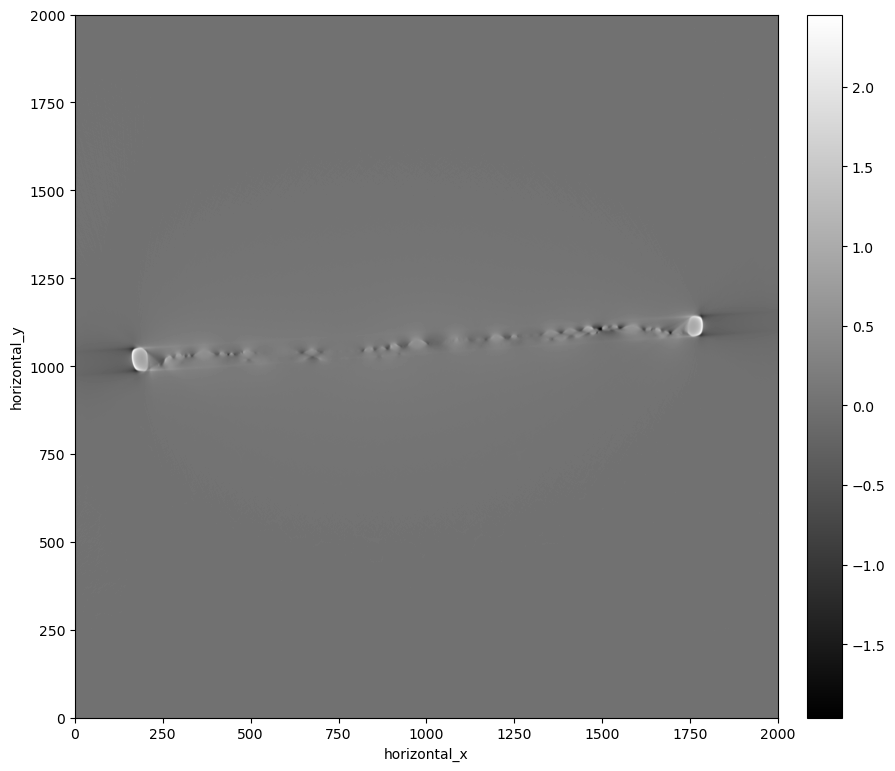

In [270]:
A = ProjectionOperator(ig, ag, direct_method='Siddon', device='gpu')
recon = FDK(data).run()
show2D(recon)

(array([  4.,   3.,   4.,   1.,   3.,   8.,   5.,   5.,   4.,   5.,   4.,
          3.,   3.,   5.,   3.,   3.,   7.,   4.,   1.,   4.,   5.,   3.,
          4.,   5.,   2.,   5.,   5.,   4.,   3.,   3.,   5.,   3.,   1.,
          6.,   3.,   5.,   3.,   7.,  23.,  76.,  52.,  65., 128.,  94.,
         79.,  73.,  62.,  68.,  73.,  51.,  43.,  42.,  42.,  46.,  34.,
         33.,  56.,  49.,  32.,  37.,  44.,  41.,  47.,  45.,  30.,  35.,
         27.,  33.,  33.,  33.,  37.,  32.,  44.,  49.,  36.,  42.,  37.,
         47.,  41.,  47.,  42.,  43.,  57.,  57.,  61.,  70.,  74.,  82.,
         95.,  69.,  84.,  57.,  33.,  18.,  27.,  31.,  27.,  19.,   4.,
          3.]),
 array([2.08371735, 2.0965991 , 2.10948062, 2.12236238, 2.13524389,
        2.14812565, 2.16100717, 2.17388892, 2.18677044, 2.19965219,
        2.21253371, 2.22541547, 2.23829699, 2.25117874, 2.26406026,
        2.27694201, 2.28982353, 2.30270529, 2.31558681, 2.32846856,
        2.34135008, 2.35423183, 2.36711335, 2.

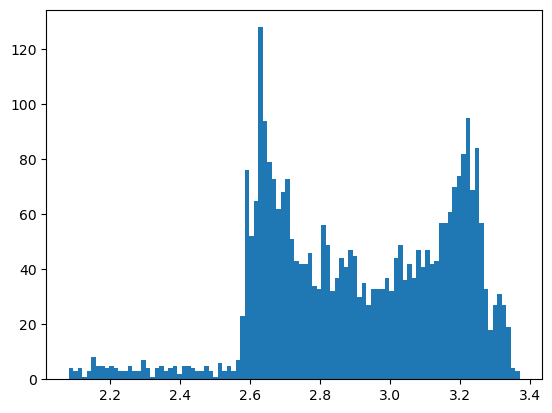

In [271]:
plt.hist(np.max(data.as_array(), axis=1),bins=100)

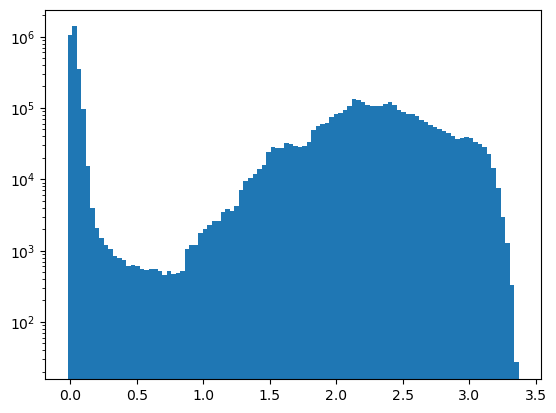

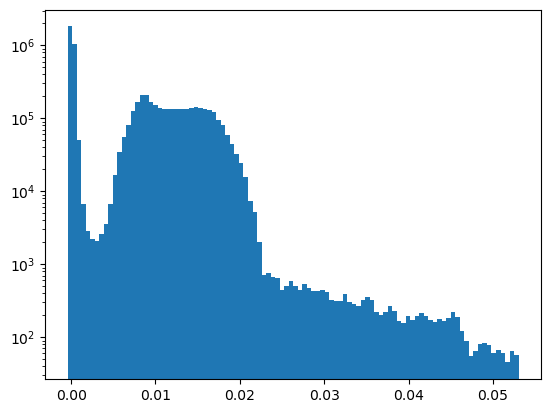

FDK recon

Input Data:
	angle: 3142
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



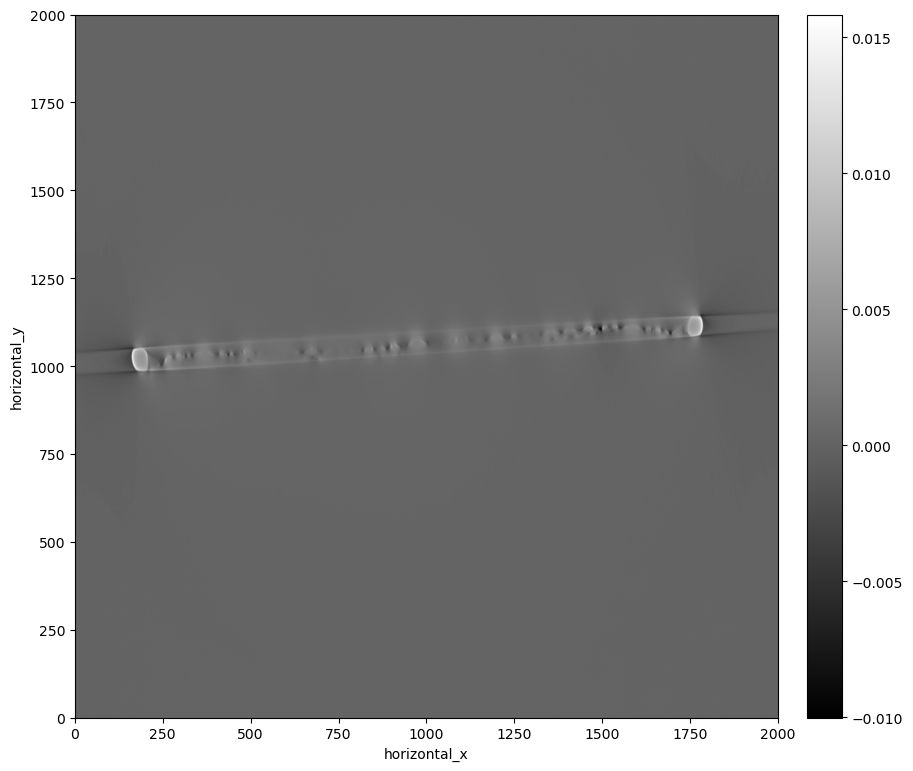

In [265]:
plt.hist(data.as_array().flatten(), bins=100)
plt.yscale('log')
plt.show()
# new_arr = data.shape[1] * data.as_array() / np.power(np.sum(data.as_array(), axis=1)[:,None], 3)
# new_arr = np.abs(data.as_array()-1) / np.power(np.sum(data.as_array(), axis=1)[:,None], 0.5)
new_arr = data.as_array() / np.power(np.max(data.as_array(), axis=1)[:,None], 5)
1+np.linspace(0,data.shape[1],data.shape[1])
data = AcquisitionData(array=new_arr,geometry=data.geometry)
plt.hist(data.as_array().flatten(), bins=100)
plt.yscale('log')
plt.show()

A = ProjectionOperator(ig, ag, direct_method='Siddon', device='gpu')

recon = FDK(data).run()
show2D(recon)

[ -95.        -95.11456   -95.229126 ... -454.6001   -454.7146
 -454.82922 ]


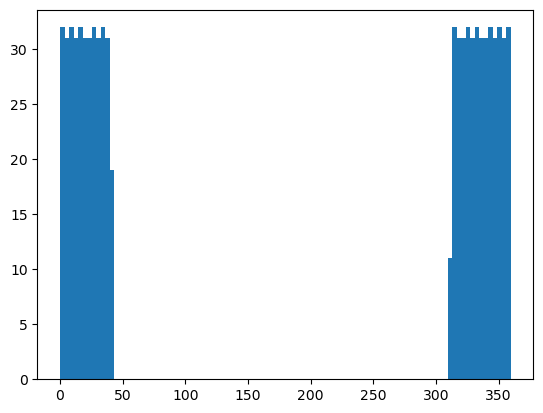

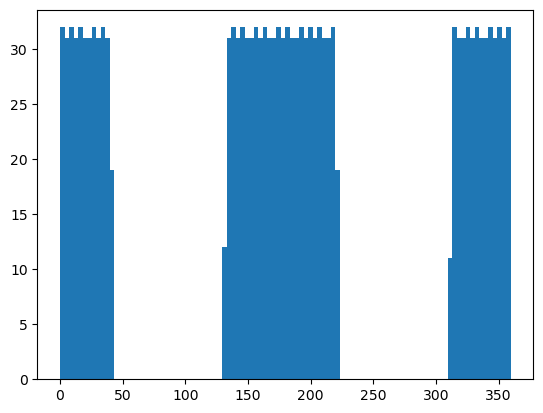

In [165]:
def angles_close_to_angle(angle_arr,chosen_angle,max_diff):
    diffs = np.mod(ag.angles - chosen_angle + 180, 360)
    return (diffs < 180 + max_diff) * (diffs > 180 - max_diff)

chosen_angle = -3.2
print(ag.angles)
max_diff = 75
is_close = angles_close_to_angle(ag.angles,chosen_angle,max_diff)
plt.hist(np.mod(ag.angles[is_close], 360),bins=100)
plt.show()
is_close_reflected = angles_close_to_angle(ag.angles,chosen_angle+180,max_diff)
plt.hist(np.mod(ag.angles[np.logical_or(is_close, is_close_reflected)], 360),bins=100)
plt.show()

In [166]:
# ag.__dir__()
# ag.config.__dir__()

In [167]:
# ag.config.system.geometry.__dir__()

In [168]:
new_arr = data.as_array()[np.logical_or(is_close, is_close_reflected),:]
ag.set_angles(ag.angles[np.logical_or(is_close, is_close_reflected)])
data = AcquisitionData(array=new_arr,geometry=data.geometry)

In [169]:
# np.s_[2:4,2:10:2]

FDK recon

Input Data:
	angle: 1570
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



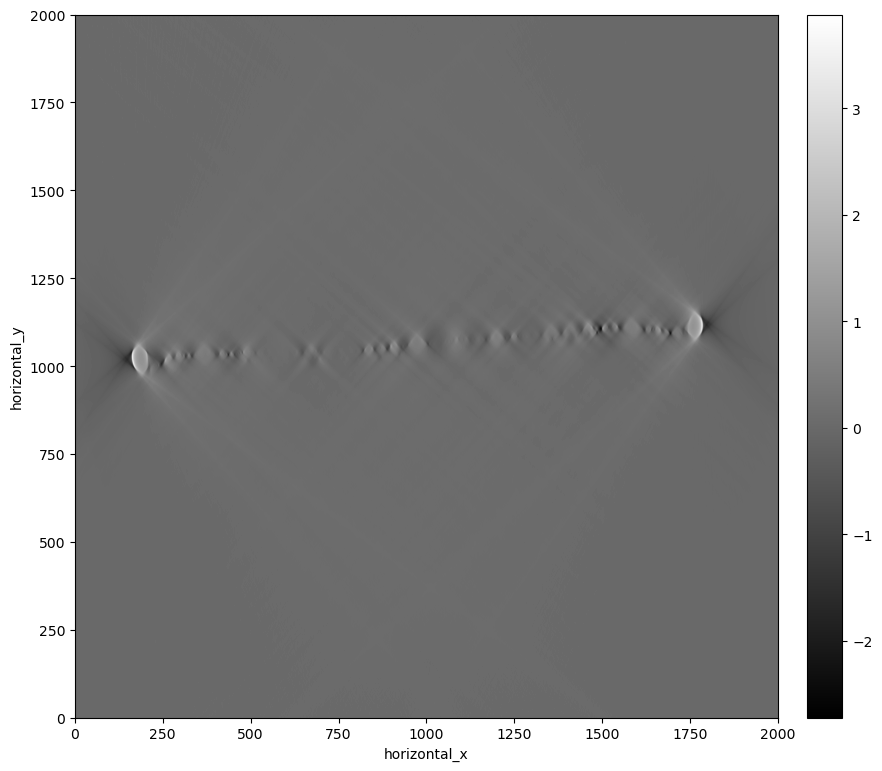

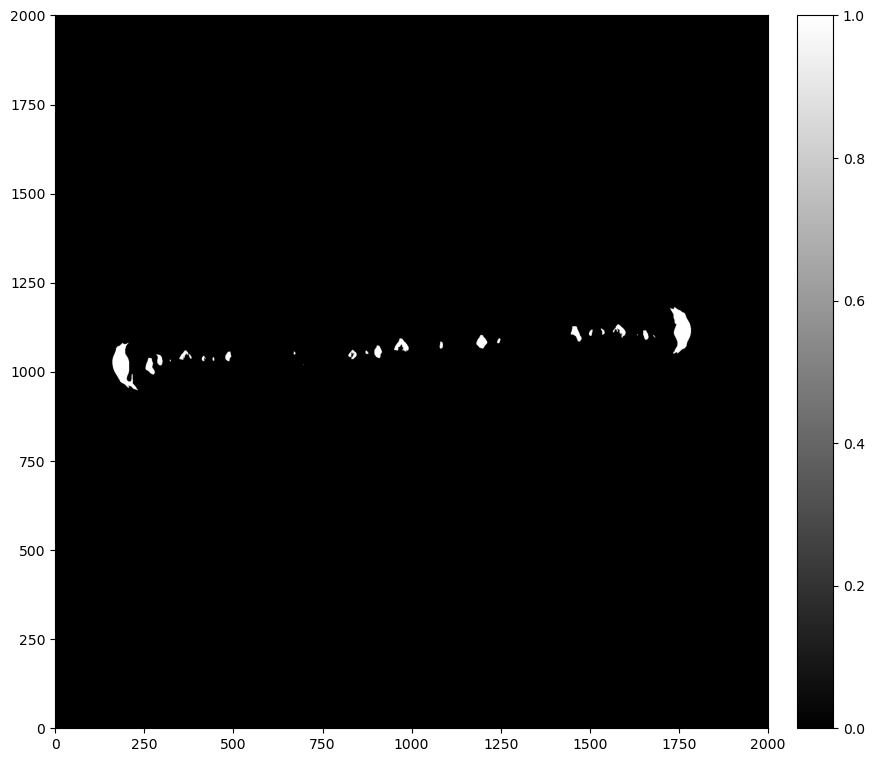

In [170]:
A = ProjectionOperator(ig, ag, direct_method='Siddon', device='gpu')

recon = FDK(data).run()
show2D(recon)
show2D(recon > 0.5)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.09060e+07
       10       1000         1.439          2.80597e+05
       20       1000         1.385          1.40657e+05
       30       1000         1.368          1.08884e+05
       40       1000         1.334          9.86740e+04
       50       1000         1.316          9.49530e+04
-------------------------------------------------------
       50       1000         1.316          9.49530e+04
Stop criterion has been reached.



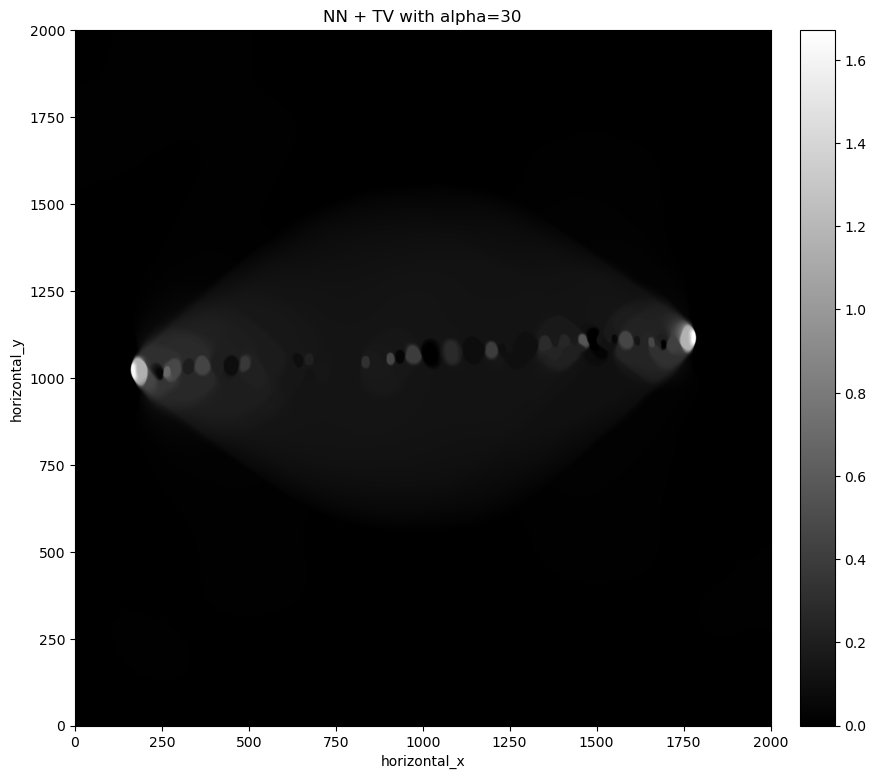

In [172]:
ig = ag.get_ImageGeometry()
alpha = 30
F = LeastSquares(A, data)
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')
#fista_TV = FISTA(initial=recont, f=F, g=TV, max_iteration=1000, update_objective_interval=10)
fista_TV = FISTA(initial=ig.allocate(0.0), f=F, g=TV, max_iteration=1000, update_objective_interval=10)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       50       1000         1.316          9.49530e+04
       60       1000         1.300          9.34050e+04
       70       1000         1.287          9.26504e+04
       80       1000         1.276          9.22512e+04
       90       1000         1.272          9.20658e+04
      100       1000         1.266          9.19651e+04
-------------------------------------------------------
      100       1000         1.266          9.19651e+04
Stop criterion has been reached.



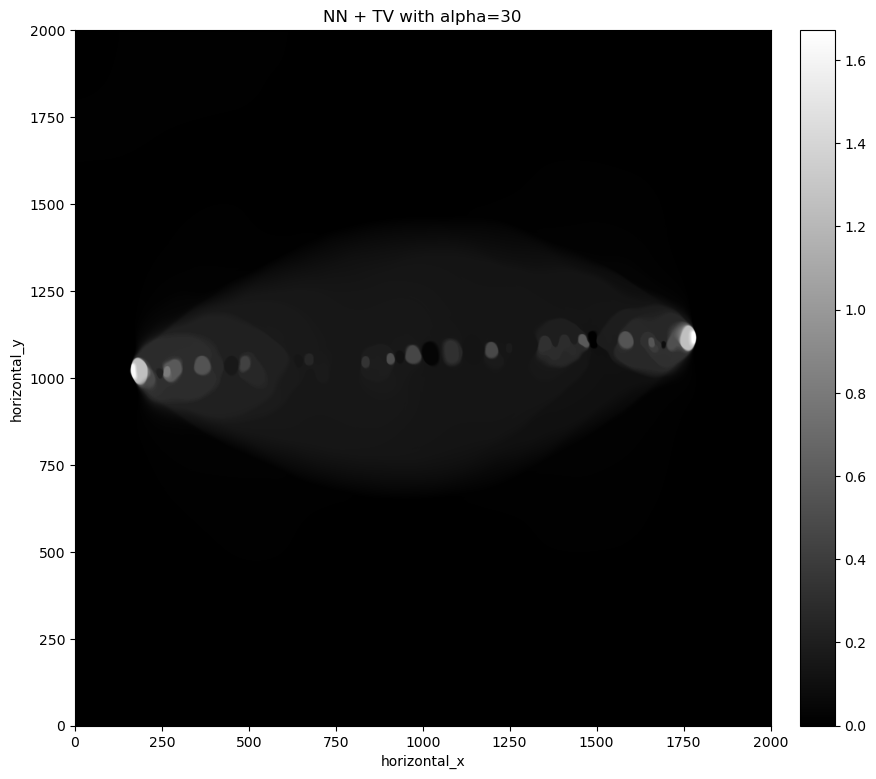

In [173]:
fista_TV.run(50, verbose=1)
show2D(fista_TV.solution,title=f'NN + TV with alpha={alpha}')